# Лабораторная работа №3

### Реконструкция матрицы плотности методом максимального правдоподобия, оценка адекватности и точности реконструкции

In [1]:
import numpy as np
from scipy.linalg import sqrtm
import copy

Определим функцию, которая генерирует $m$ случайных базисов.

In [2]:
def get_random_bases(d, m):
    list_bases_matrix = []
    for i in range(m):
        g = np.random.randn(d, d) + 1j * np.random.randn(d, d)
        q, r = np.linalg.qr(g)
        list_bases_matrix.append(q)
    return list_bases_matrix

Определим функцию, которая составляет матрицы операторов $P_{j, k}$ для рассматриваемого протокола измерений.

In [3]:
def get_P_j_k(list_bases_matrix, d):
    list_P = []
    for j in range(len(list_bases_matrix)):
        list_P_row = []
        for k in range(d):
            phi_j_k = list_bases_matrix[j].T[k]
            p_j_k = np.dot(phi_j_k.reshape((d, 1)), phi_j_k.conjugate().reshape((1, d)))
            list_P_row.append(p_j_k)
        list_P.append(list_P_row)
    return list_P

Определим функцию, которая составляет матрицу измерений $B$ для рассматриваего протокола измерений.

In [4]:
def get_B(list_bases_matrix, d):
    list_B_rows = []
    list_P = get_P_j_k(list_bases_matrix, d)
    for j in range(len(list_bases_matrix)):
        for k in range(d):
            list_B_rows.append(list_P[j][k].reshape(-1, order='C'))
    b = np.vstack(tuple(list_B_rows))
    return b

Определим функцию, которая вытягивает матрицу плотности размером $d \times d$ в столбец.

In [5]:
def get_vec_rho(rho, d):
    return rho.reshape(-1, order='F').reshape((d ** 2, 1))

Определим функцию, которая на основе правила Борна определяет вероятности получения результатов измерений.

In [6]:
def get_P_born(P_matrix, rho, d, m):
    p_born = np.zeros((m, d))
    for j in range(m):
        for k in range(d):
            p_born[j, k] = np.trace(np.dot(P_matrix[j][k], rho)).real
    return p_born

Определим функцию, которая на основе матрицы $X$ определяет вероятности получения результатов измерений.

In [7]:
def get_P_X(X, pure_state, d, m):
    M = np.dot(X, pure_state)
    return (np.abs(M) ** 2).reshape((m, d))

Опредедим функцию, которая на основе матрицы $B$ определяет вероятности получения результатов измерений.

In [8]:
def get_P_B(B, rho, d, m):
    p_B = np.dot(B, get_vec_rho(rho, d)).real
    return p_B.reshape((m, d))

Создаём функцию, которая делает проекцию матрицы, полученной с помощью томографии на множество матриц плотности.

In [9]:
def get_rho_projection(rho_exp, d):
    D, U = np.linalg.eig(rho_exp)
    D_extend = []
    for j in range(0, d, 1):
        D_extend.append([D[j], j])
    D_extend_sorted = sorted(D_extend, key=lambda x: -x[0])
    w_list = []
    lambda_minus_w_list = []
    for j in range(0, d, 1):
        w_list.append((np.sum(np.array(D_extend_sorted)[0:(j + 1), 0]) - 1) / (j + 1))
        lambda_minus_w_list.append(D_extend_sorted[j][0] - w_list[j])
    j_0 = -1
    for j in range(0, d, 1):
        if lambda_minus_w_list[j] > 0:
            j_0 = j
    if j_0 == -1:
        for j in range((j_0 + 1), d, 1):
            D_extend_sorted[j][0] = 0
    else:
        w = w_list[j_0]
        for j in range(0, j_0 + 1, 1):
            D_extend_sorted[j][0] -= w
        for j in range((j_0 + 1), d, 1):
            D_extend_sorted[j][0] = 0
    D_new = []
    for j in range(0, d, 1):
        D_new.append(D_extend_sorted[D_extend_sorted[j][1]][0])
    D_new = np.diag(D_new)
    rho_new = np.dot(U, np.dot(D_new, U.T.conjugate()))
    return rho_new

Создаём функцию, которая генерирует матрицу $I$.

In [10]:
def get_I(n, P_j_k):
    I = np.zeros_like(P_j_k[0][0], dtype=complex)
    for i in range(len(P_j_k)):
        for j in range(len(P_j_k[0])):
            I += n * P_j_k[i][j]
    return I

Создаём функцию, которая генерирует матрицу $J$.

In [11]:
def get_J(counts_matrix, psi_r, P_j_k):
    J = np.zeros_like(P_j_k[0][0], dtype=complex)
    for i in range(len(P_j_k)):
        for j in range(len(P_j_k[0])):
            J += (counts_matrix[i, j] / get_P_born(P_j_k, np.dot(psi_r, psi_r.T.conjugate()), d, m)[i, j]) * P_j_k[i][j]
    return J

Определяем квадрат нормы Фробениуса для матрицы.

In [12]:
def get_frobenius_norm(a):
    return np.sum(np.abs(a) ** 2)

Определяем фиделити между двумя матрицами плотности.

In [13]:
def fidelity(rho, sigma):
    return np.abs(np.trace(sqrtm(sqrtm(rho) @ sigma @ sqrtm(rho)))) ** 2

Создаём функцию генерации статистических данных измерений.

In [14]:
def simulation_result_measures(B, rho, n, d, m):
    p = get_P_B(B, rho, d, m)
    counts_matrix = np.zeros_like(p)
    for j in range(len(p)):
        counts_matrix[j] = np.random.multinomial(n, p[j], size=1)
    return counts_matrix

Создаём функцию реконструкции состояния методом псевдоинверсии.

In [15]:
def reconstruction_pseudo_inv(counts_matrix, B, n, d):
    p_exp = counts_matrix / n
    U, S, V_dagger = np.linalg.svd(B)
    q = np.dot(U.T.conjugate(), p_exp.reshape(-1))
    f = q[0:(d ** 2)] / S
    rho_exp = np.dot(V_dagger.T.conjugate(), f)
    rho_exp = rho_exp.reshape((d, d), order='F')
    rho_exp = get_rho_projection(rho_exp, d)
    return rho_exp

Создаём функцию реконструкции состояния методом максимального правдоподобия.

In [16]:
def reconstruction_mmp(counts_matrix, B, P_matrix, n, d, eps, r, mu=0.5):
    rho_exp_pseudo_inv = reconstruction_pseudo_inv(counts_matrix, B, n, d)
    D, U = np.linalg.eig(rho_exp_pseudo_inv)
    idx = D.argsort()[::-1]
    D = D[idx]
    U = U[:, idx]
    psi_pseudo_inv_truncate = np.dot(U[:, 0:r], np.sqrt(np.diag(D))[0:r, 0:r])
    psi_r = psi_pseudo_inv_truncate
    psi_r_prev = copy.copy(psi_r)
    iteration = 1
    while (np.sqrt(get_frobenius_norm(psi_r - psi_r_prev)) > eps) or iteration == 1:
        psi_r_prev = copy.copy(psi_r)
        psi_r = (1 - mu) * np.dot(np.linalg.inv(get_I(n, P_matrix)), np.dot(get_J(counts, psi_r, P_matrix), psi_r)) + mu * psi_r
        iteration += 1
    rho_exp_mmp = np.dot(psi_r, psi_r.T.conjugate())
    return rho_exp_pseudo_inv, rho_exp_mmp

Создаём функцию, которая вычисляет величину $\chi$-квадрат относительно реконструированной матрицы плотности $\rho$.

In [17]:
def get_chi2(counts_matrix, rho_exp, B, n, d, m):
    p = get_P_B(B, rho_exp, d, m)
    chi2 = 0
    for i in range(len(p)):
        for j in range(len(p[0])):
            chi2 += ((counts_matrix[i, j] - p[i, j] * n) ** 2) / (p[i, j] * n)
    return chi2

Создаём функцию, которая генерирут случайное чистое состояние.

In [18]:
def get_random_pure_state(d):
    state = np.random.randn(d) + 1j * np.random.randn(d)
    state = state / np.sqrt(np.sum(state * np.conjugate(state)))
    return state

In [19]:
d = 3 # Размерность квантовой системы
m = 10 # Количество случайных базисов
eps = 1e-8 # Необходимая точность для остановки итерационной процедуры в методе максимального правдоподобия
n = 100 # Количество измерений в одном базисе
number = 100 # Количесьво генераций статистических данных
# r_list = list(map(int, np.linspace(1, d, d))) # Список рассматриваемых рангов
r_list = [1]

Генерируем $m$ случайных базисов.

In [20]:
list_bases_matrix = get_random_bases(d, m)

Генерируем операторы измерения в случайных базисах и матрицу протокола измерений $B$.

In [21]:
P_matrix = get_P_j_k(list_bases_matrix, d)
B = get_B(list_bases_matrix, d)

Генерируем случайное чистое состояние.

In [22]:
pure_state = get_random_pure_state(d)
pure_rho = np.dot(pure_state.reshape((d, 1)), pure_state.reshape((1, d)).conjugate())

In [23]:
fidelity_mmp_list = []
chi2_mmp_list = []
fidelity_pseudo_inv_list = []
chi2_pseudo_inv_list = []
for r in r_list:
    fidelity_mmp_list_r = []
    chi2_mmp_list_r = []
    fidelity_pseudo_inv_list_r = []
    chi2_pseudo_inv_list_r = []
    
    for sample in range(number):
        print('sample = ', sample, 'rank = ', r)
        
        counts = simulation_result_measures(B, pure_rho, n, d, m)
        rho_exp_pseudo_inv, rho_exp_mmp = reconstruction_mmp(counts, B, P_matrix, n, d, eps, r)
        
        fidelity_mmp_list_r.append(fidelity(pure_rho, rho_exp_mmp))
        fidelity_pseudo_inv_list_r.append(fidelity(pure_rho, rho_exp_pseudo_inv))
        chi2_mmp_list_r.append(get_chi2(counts, rho_exp_mmp, B, n, d, m))
        chi2_pseudo_inv_list_r.append(get_chi2(counts, rho_exp_pseudo_inv, B, n, d, m))
    
    fidelity_mmp_list.append((r, fidelity_mmp_list_r))
    fidelity_pseudo_inv_list.append((r, fidelity_pseudo_inv_list_r))
    chi2_mmp_list.append((r, chi2_mmp_list_r))
    chi2_pseudo_inv_list.append((r, chi2_pseudo_inv_list_r))

sample =  0 rank =  1
sample =  1 rank =  1
sample =  2 rank =  1
sample =  3 rank =  1
sample =  4 rank =  1
sample =  5 rank =  1
sample =  6 rank =  1
sample =  7 rank =  1
sample =  8 rank =  1
sample =  9 rank =  1
sample =  10 rank =  1
sample =  11 rank =  1
sample =  12 rank =  1
sample =  13 rank =  1
sample =  14 rank =  1
sample =  15 rank =  1
sample =  16 rank =  1
sample =  17 rank =  1
sample =  18 rank =  1
sample =  19 rank =  1
sample =  20 rank =  1
sample =  21 rank =  1
sample =  22 rank =  1
sample =  23 rank =  1
sample =  24 rank =  1
sample =  25 rank =  1
sample =  26 rank =  1
sample =  27 rank =  1
sample =  28 rank =  1
sample =  29 rank =  1
sample =  30 rank =  1
sample =  31 rank =  1
sample =  32 rank =  1
sample =  33 rank =  1
sample =  34 rank =  1
sample =  35 rank =  1
sample =  36 rank =  1
sample =  37 rank =  1
sample =  38 rank =  1
sample =  39 rank =  1
sample =  40 rank =  1
sample =  41 rank =  1
sample =  42 rank =  1
sample =  43 rank =  

Определяем число степеней свободы $\nu$.

In [24]:
m_full = m * d
m_b = m
nu_p = [(2 * d - r) * r - 1 for r in r_list]
nu_list = [m_full - m_b - nu_p_fix for nu_p_fix in nu_p]

In [25]:
nu_list

[16]

In [26]:
from scipy import stats

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

#### p-value и fidelity для ранга 1

#### Метод максимального правдоподобия

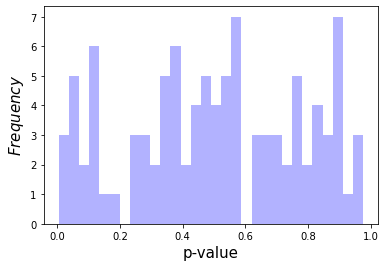

In [28]:
plt.hist(1 - stats.chi2.cdf(chi2_mmp_list[0][1], nu_list[0]), bins=30, color='blue', alpha=0.3)
plt.xlabel('p-value', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

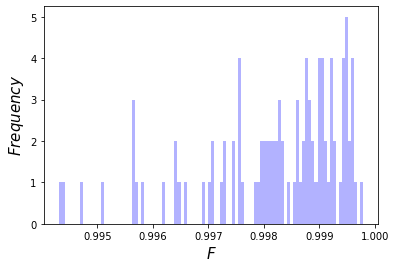

In [29]:
plt.hist(fidelity_mmp_list[0][1], bins=100, color='blue', alpha=0.3)
plt.xlabel(r'$F$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

#### Метод псевдоинверсии

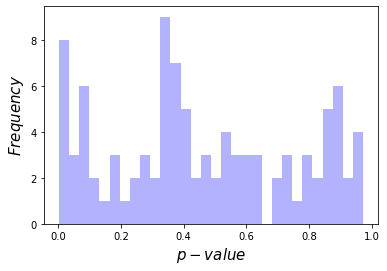

In [30]:
plt.hist(1 - stats.chi2.cdf(chi2_pseudo_inv_list[0][1], nu_list[0]), bins=30, color='blue', alpha=0.3)
plt.xlabel(r'$p-value$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

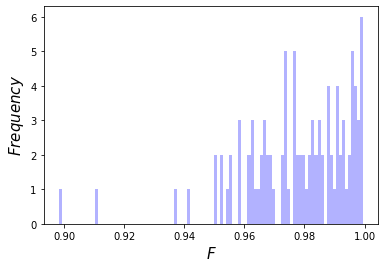

In [31]:
plt.hist(fidelity_pseudo_inv_list[0][1], bins=100, color='blue', alpha=0.3)
plt.xlabel(r'$F$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

#### Диаграмма рассеяния (чтобы понять, как ММП улучшает фиделити)

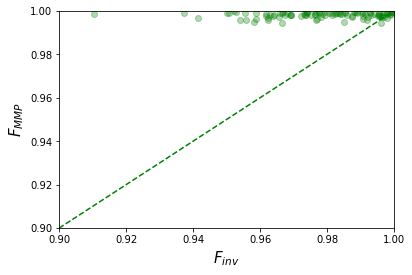

In [34]:
plt.scatter(fidelity_pseudo_inv_list[0][1], fidelity_mmp_list[0][1], color='green', alpha=0.3)
plt.plot([0, 1], [0, 1], '--', color='green')
plt.xlabel(r'$F_{inv}$', fontsize=15)
plt.ylabel(r'$F_{MMP}$', fontsize=15)
plt.xlim(0.9, 1)
plt.ylim(0.9, 1.0001)
plt.show()

#### p-value и fidelity для ранга 2

#### Метод максимального правдоподобия

In [ ]:
plt.hist(1 - stats.chi2.cdf(chi2_mmp_list[1][1], nu_list[1]), bins=30, color='blue', alpha=0.3)
plt.xlabel('p-value', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

In [ ]:
plt.hist(fidelity_mmp_list[1][1], bins=100, color='blue', alpha=0.3)
plt.xlabel(r'$F$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

#### Метод псевдоинверсии

In [ ]:
plt.hist(1 - stats.chi2.cdf(chi2_pseudo_inv_list[1][1], nu_list[1]), bins=30, color='blue', alpha=0.3)
plt.xlabel(r'$p-value$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

In [ ]:
plt.hist(fidelity_pseudo_inv_list[1][1], bins=100, color='blue', alpha=0.3)
plt.xlabel(r'$F$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

#### Диаграмма рассеяния (чтобы понять, как ММП улучшает фиделити)

In [ ]:
plt.scatter(fidelity_pseudo_inv_list[1][1], fidelity_mmp_list[1][1], color='green', alpha=0.3)
plt.plot([0, 1], [0, 1], '--', color='green')
plt.xlabel(r'$F_{inv}$', fontsize=15)
plt.ylabel(r'$F_{MMP}$', fontsize=15)
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.show()

#### p-value и fidelity для ранга 3

#### Метод максимального правдоподобия

In [ ]:
plt.hist(1 - stats.chi2.cdf(chi2_mmp_list[2][1], nu_list[2]), bins=30, color='blue', alpha=0.3)
plt.xlabel('p-value', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

In [ ]:
plt.hist(fidelity_mmp_list[2][1], bins=100, color='blue', alpha=0.3)
plt.xlabel(r'$F$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

#### Метод псевдоинверсии

In [ ]:
plt.hist(1 - stats.chi2.cdf(chi2_pseudo_inv_list[2][1], nu_list[2]), bins=30, color='blue', alpha=0.3)
plt.xlabel(r'$p-value$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

In [ ]:
plt.hist(fidelity_pseudo_inv_list[2][1], bins=100, color='blue', alpha=0.3)
plt.xlabel(r'$F$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

#### Диаграмма рассеяния (чтобы понять, как ММП улучшает фиделити)

In [ ]:
plt.scatter(fidelity_pseudo_inv_list[2][1], fidelity_mmp_list[2][1], color='green', alpha=0.3)
plt.plot([0, 1], [0, 1], '--', color='green')
plt.xlabel(r'$F_{inv}$', fontsize=15)
plt.ylabel(r'$F_{MMP}$', fontsize=15)
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.show()

Видно, что лучше всего работает модель с $r = 1$.

Создаём функцию, которая преобразует матрицу состояния в вектор действительных чисел.

In [ ]:
def state_real(psi_r):
    d, r = psi_r.shape
    psi = psi_r.reshape((d * r, 1), order='F')
    psi = np.vstack((np.real(psi), np.imag(psi)))
    return psi

Создаём функцию, которая гененирует действительную матрицу $P_j$.

In [ ]:
def p_j_real(p_j, r):
    d = p_j.shape[0]
    p_j = np.kron(np.eye(r), p_j)
    p_j = np.block([[np.real(p_j), -np.imag(p_j)], 
                    [np.imag(p_j), np.real(p_j)]])
    return p_j

Создаём функцию, которая генерирует матрицу полной информации.

In [ ]:
def get_H(psi_r, r, P_matrix, B, n, d, m):
    rho = np.dot(psi_r.reshape((d, r)), psi_r.reshape((r, d)).conjugate())
    p = get_P_B(B, rho, d, m)
    H = np.zeros((2 * d * r, 2 * d * r), dtype=complex)
    psi = state_real(psi_r)
    for i in range(len(P_matrix)):
        for j in range(len(P_matrix[0])):
            P_i_j = p_j_real(P_matrix[i][j], r)
            H += (2 * n / p[i, j]) * np.dot(np.dot(P_i_j, psi), np.dot(P_i_j, psi).T)
    return H

Вычисляем средние потери точности и их дисперсии.

In [ ]:
r = 1
pure_state = pure_state.reshape((d, 1))
H = get_H(pure_state, r, P_matrix, B, n, d, m)
eig_vals, _ = np.linalg.eig(H)

In [ ]:
i_max = 0
max_eig = eig_vals[0]
for i in range(len(eig_vals)):
    if max_eig < eig_vals[i]:
        i_max = i
        max_eig = eig_vals[i]
eig_vals = list(eig_vals)
eig_vals.pop(i_max)
eig_vals = list(filter(lambda x: abs(x) > 1e-10, eig_vals))

In [ ]:
eig_vals

In [ ]:
d_list = 1 / (2 * np.array(eig_vals))
infidelity_mean_analytics = np.sum(d_list)
infidelity_disp_analytics = 2 * np.sum(d_list ** 2)

In [ ]:
print('Infidelity_mean_analytics = ', infidelity_mean_analytics.real, ', Infidelity_disp_analytics = ', infidelity_disp_analytics.real)
print('Infidelity_mean = ', (1 - np.array(fidelity_mmp_list[0][1])).mean(), ', Infidelity_disp = ', (((1 - np.array(fidelity_mmp_list[0][1])).std())) ** 2)